## Microsoft Data Scientist Assignment
### Project: Filter noisy GPS data
### Vasily Korf, Sep 2017

### Goal

Import and explore the datasets, develop a model to filter noisy data.


### Import *.kml file

I know about the existence of several kml libraries : 

1. fastkml https://github.com/cleder/fastkml
2. simplekml https://pypi.python.org/pypi/simplekml/1.2.7
3. pykml https://pythonhosted.org/pykml/tutorial.html

But I saved input file as text file, picked only coordinates tag with parser as a fast solution.

In [1]:
# Import libraries necessary for this project
!pip install geopy 

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display 

    100% |################################| 71kB 1.7MB/s ta 0:00:01


In [2]:
# Create df
df = pd.read_csv('sensor.txt', header = None, delimiter=',', lineterminator = ' ', 
                    names = ['longitude','latitude','attitude'])
df.head(3)

,longitude,latitude,attitude
0,13.323018,52.499687,0
1,13.323018,52.499687,0
2,13.323018,52.499687,0


In [3]:
df.describe()

,longitude,latitude,attitude
count,4750.000000,4750.000000,4750.0
mean,13.315562,52.478245,0.0
std,0.023848,0.012442,0.0
min,13.281027,52.460250,0.0
25%,13.301350,52.465750,0.0
50%,13.308040,52.475087,0.0
75%,13.323645,52.488617,0.0
max,13.370587,52.500595,0.0


**Data insight:** attitude column has no information.

In [4]:
# Drop attitude column
del df['attitude']

### Explore date

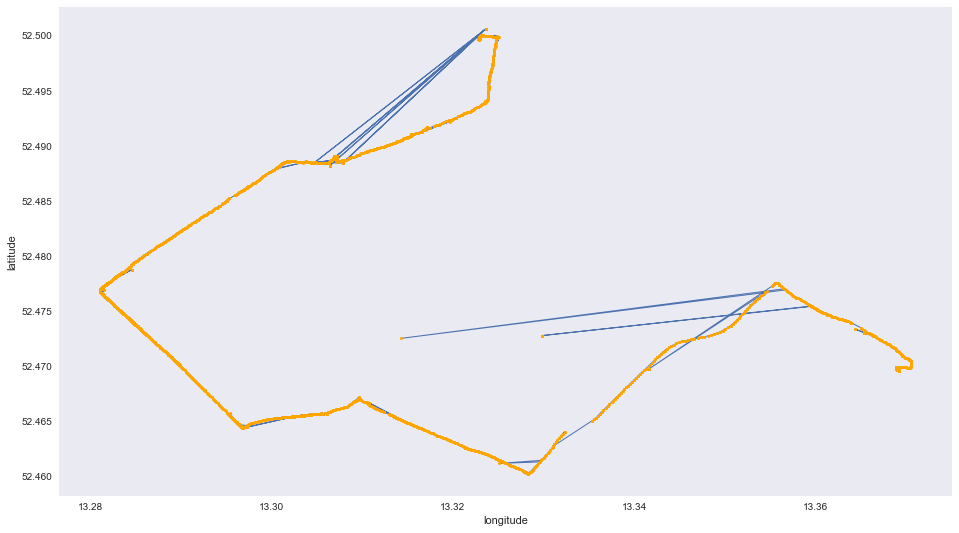

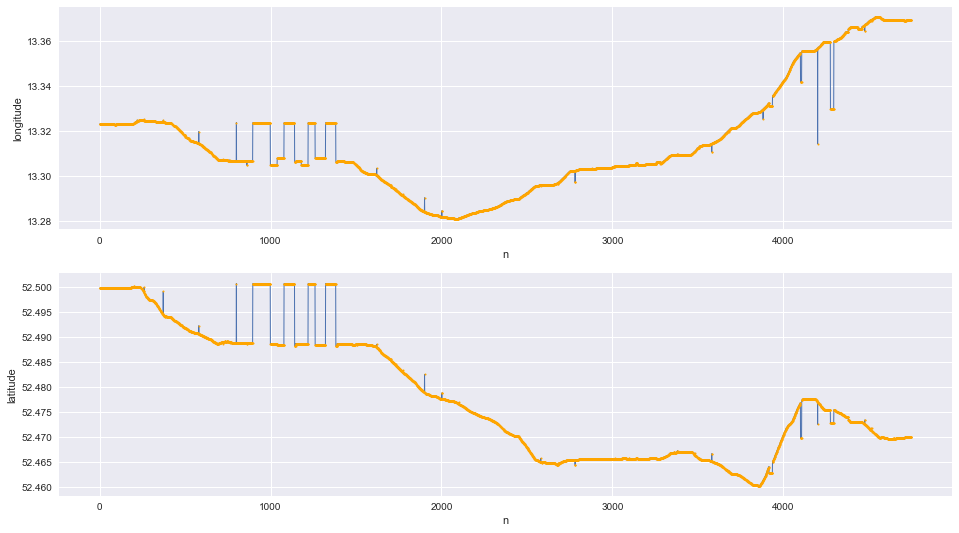

In [43]:
# Plot 
plt.rcParams["figure.figsize"] = [16,9]
plt.plot(df['longitude'], df['latitude'], '-o', ms=3, lw=1, alpha=1, mfc='orange')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.grid()
plt.show()

plt.figure(1)
plt.subplot(211)
plt.plot(df['longitude'], '-o', ms=2, lw=1, alpha=1, mfc='orange')
plt.ylabel('longitude')
plt.xlabel('n')

plt.subplot(212)
plt.plot(df['latitude'], '-o', ms=2, lw=1, alpha=1, mfc='orange')
plt.ylabel('latitude')
plt.xlabel('n')
plt.show()

**Data insight:** Outliers are synchronous in terms of latitude and longitude parameters. High volume noise around 800-1400 and 4100-4300 ranges.

### Original distance traveled by the vehicle including the false data points

I picked Vincenty way to compute distance using geopy library:

https://pypi.python.org/pypi/geopy

https://www.jasondavies.com/maps/distance/ - the reason for choosing

https://en.wikipedia.org/wiki/Great-circle_distance

In [6]:
from geopy.distance import vincenty

# Loop for vincenty distance

dist = [0]

for index, row in df.iterrows():
    
    if index == (len(df)-1):
        break
        
    # Set A, B points    
    x1 = df['longitude'][index]
    x2 = df['longitude'][index+1]
    y1 = df['latitude'][index]
    y2 = df['latitude'][index+1]
    calc = vincenty((x1,y1),(x2,y2)).miles
    
    # Save
    dist.append(calc)

# Add to dataframe   
df['vincenty_miles'] = dist

# Convert to km
df['vincenty_km'] = df['vincenty_miles'] * 1.609344

# Print results
print 'Total distance traveled (miles): ', "%.2f" % df['vincenty_miles'].sum()
print 'Total distance traveled (kilometers): ', "%.2f" % df['vincenty_km'].sum()

Total distance traveled (miles):  45.36
Total distance traveled (kilometers):  73.00


### Filter out the incorrect data points

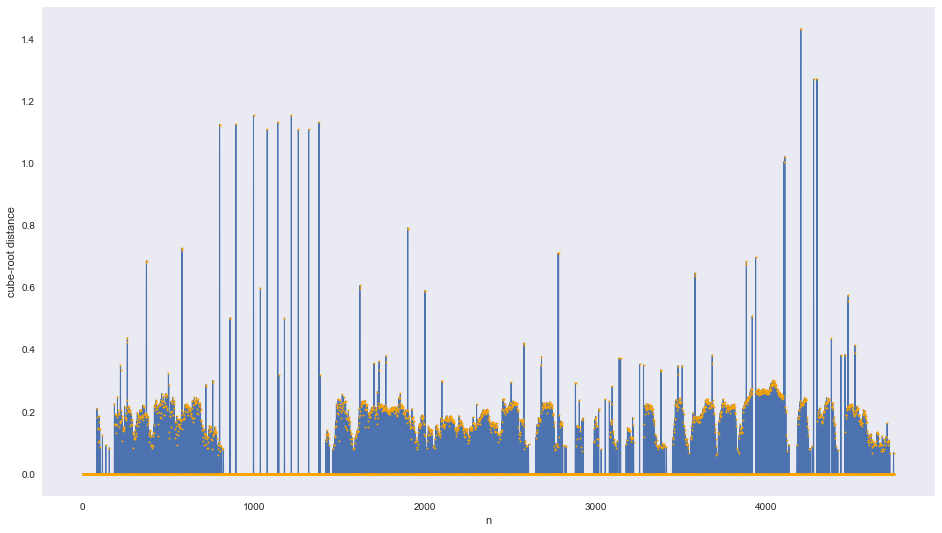

In [7]:
# Plot cube-root distance
plt.rcParams["figure.figsize"] = [16,9]

plt.plot(np.cbrt(df['vincenty_miles']), '-o', ms=2, lw=1, alpha=1, mfc='orange')
plt.ylabel('cube-root distance')
plt.xlabel('n')
axes = plt.gca()
#axes.set_ylim([0,0.03])
plt.grid()
plt.show()

**Data insight:** cube-root transformation works well for distance. You may notice benchmark for the filter.

In [8]:
# Make a copy
data = df.copy()
# Add cube-root distance
data['vinc_croot'] = np.cbrt(data['vincenty_miles'])
# Drop duplicates
data.drop_duplicates(inplace = True)
# Reset index
data = data.reset_index(drop=True)
# Make a copy for filtered data
data_filter = data.copy()

In [9]:
# Check std as a main parameter for filter
data.describe()

,longitude,latitude,vincenty_miles,vincenty_km,vinc_croot
count,3210.000000,3210.000000,3210.000000,3210.000000,3210.000000
mean,13.314513,52.476471,0.013707,0.022059,0.100441
std,0.025569,0.011063,0.122419,0.197014,0.132210
min,13.281027,52.460250,0.000000,0.000000,0.000000
25%,13.295194,52.466122,0.000000,0.000000,0.000000
50%,13.308556,52.474052,0.000496,0.000798,0.079165
75%,13.324396,52.488220,0.006577,0.010585,0.187361
max,13.370587,52.500595,2.938568,4.729167,1.432337


In [10]:
# Loop for filter
for index, row in data_filter.iterrows():
    
    if index > 0:
        
        # add filter std conditions for distance and longitude
        if data_filter['vinc_croot'][index] > 0.2*data['vinc_croot']. std() + data_filter['vinc_croot'][index-1] \
        or data_filter['longitude'][index] > 0.17*data['longitude'].std() + data_filter['longitude'][index-1] \
        or data_filter['longitude'][index] < -0.17*data['longitude'].std() + data_filter['longitude'][index-1]:
            
            #take values from previous row
            data_filter['longitude'][index] = data_filter['longitude'][index-1]
            data_filter['latitude'][index] = data_filter['latitude'][index-1]

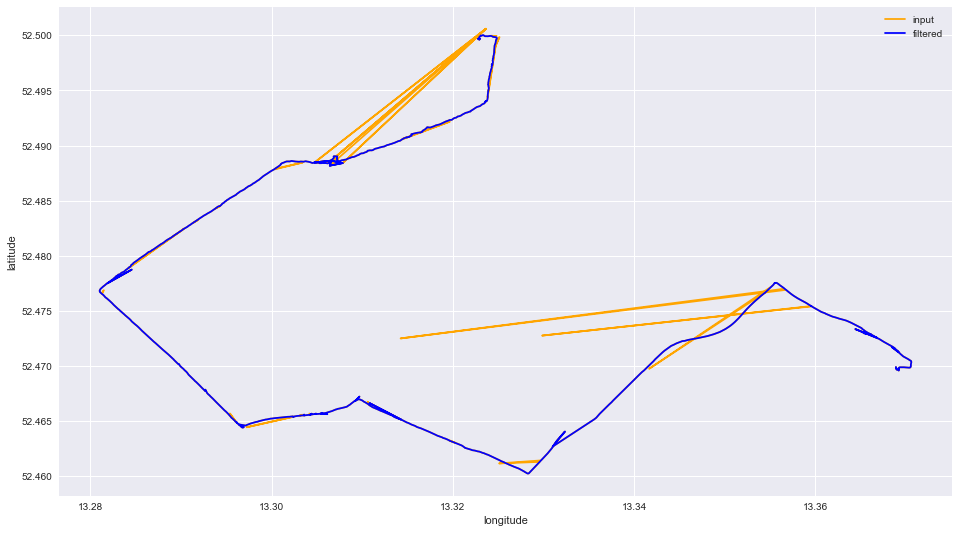

In [11]:
# Plot filter results
plt.rcParams["figure.figsize"] = [16,9]

plt.plot(data['longitude'], data['latitude'], 'orange')
plt.plot(data_filter['longitude'], data_filter['latitude'], 'blue')

plt.legend(['input', 'filtered'])
plt.ylabel('latitude')
plt.xlabel('longitude')

plt.show()

**Model insight:** The filter perfectly marked high volume outliers that we notice above. There are several clots of small movements, this can be referred to outliers as well, but I would rather stay on the current model. In any case, the code for filtering such movements using rolling median is below.

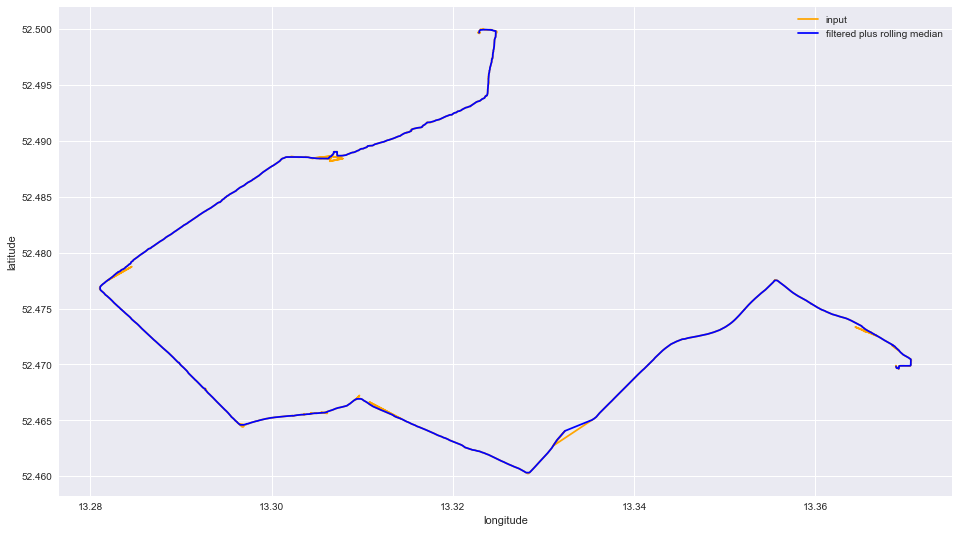

In [12]:
# Add rolling median smoothing
plt.plot(data_filter['longitude'], data_filter['latitude'], 'orange')
plt.plot(data_filter['longitude'].rolling(window=30).median(), data_filter['latitude'].rolling(window=30).median(), 'blue')
plt.legend(['input', 'filtered plus rolling median'])
plt.ylabel('latitude')
plt.xlabel('longitude')

plt.show()

In [13]:
# Loop for vincenty distance

dist_filter = [0]

for index, row in data_filter.iterrows():
    
    if index == (len(data_filter)-1):
        break
        
    x1 = data_filter['longitude'][index]
    x2 = data_filter['longitude'][index+1]
    y1 = data_filter['latitude'][index]
    y2 = data_filter['latitude'][index+1]
    calc = vincenty((x1,y1),(x2,y2)).miles
    dist_filter.append(calc)

# Add to dataframe        
data_filter['vincenty_miles'] = dist_filter

# Convert to km
data_filter['vincenty_km'] = data_filter['vincenty_miles'] * 1.609344

# Print results
print 'Total distance traveled (miles): ', "%.2f" % data_filter['vincenty_miles'].sum()
print 'Total distance traveled (kilometers): ', "%.2f" % data_filter['vincenty_km'].sum()

Total distance traveled (miles):  14.09
Total distance traveled (kilometers):  22.67


### Results

|     Distance     |Input Data | Filtered data |
| :------------: | :---------------: | :-------------: | 
    | Miles |   45.36             |      14.09         |
| Kilometers        |  73.00             |   22.67       |

### Next steps, possible improvements

1. Add automated grid search over specified parameter coefficients for a filter.
2. Add a rectangle of zone objects that can not be traversed (river, buildings etc.).